In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium

import branca
import branca.colormap as cm



from wetterdienst import Wetterdienst
from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution

from datetime import datetime, timedelta


def station_temp(name, start_date, end_date):
    request = DwdObservationRequest(parameter=[DwdObservationDataset.TEMPERATURE_AIR],
                                resolution=DwdObservationResolution.MINUTE_10,
                                start_date=start_date,
                                end_date=end_date,
                                ).filter_by_name(name=name)

    df_res = request.values.all().df.dropna()

    df_Temp=df_res[df_res.parameter=="temperature_air_mean_005"].drop(['dataset', 'parameter', 'quality'], axis=1)
    df_Temp.rename(columns={'value':'T'}, inplace=True)
    df_dew=df_res[df_res.parameter=="temperature_dew_point_mean_200"].drop(['station_id', 'dataset', 'parameter', 'quality'], axis=1)
    
    df_dew.rename(columns={'value':'Td'}, inplace=True)
    
    df_Temp.set_index(pd.DatetimeIndex(df_Temp['date']), inplace=True)
    
    
    df_dew.set_index(pd.DatetimeIndex(df_Temp['date']), inplace=True)
    
    df_out=df_Temp.merge(df_dew, how='left', left_index=True, right_index=True)
    df_out["time"]=pd.to_datetime(df_Temp.date, format="%Y-%m-%d %H:%M:%S%z").dt.tz_localize(None)
    #df_out["SEC"]=pd.to_timedelta(df_Temp.date).dt.total_seconds()
    df_out.set_index(df_out["time"], inplace=True)
    #df_out.drop(["date"], axis=1)
    #df_out.set_index("time", inplace=True)
    df_out=df_out.drop(["date_x", "date_y"], axis=1)
    df_out["T"]=df_out["T"]-273.15
    df_out["Td"]=df_out["Td"]-273.15
    return df_out



In [2]:
fn = "./dcsv/2022-05-06T18_08_35.000Z.csv"

#station="Leipzig-Holzhausen"
station="Leipzig/Halle"

ds = pd.read_csv(fn)

ds=ds[50:-50]


ds.time=pd.to_datetime(ds.time, format="%Y-%m-%dT%H:%M:%S.%fZ")

ds.set_index(pd.DatetimeIndex(ds["time"]), inplace=True)
print(ds)

                                   time        lon        lat  T[C]  Tdp[°C]  \
time                                                                           
2022-05-06 18:10:59 2022-05-06 18:10:59  11.983661  51.457039  18.6      9.6   
2022-05-06 18:11:02 2022-05-06 18:11:02  11.983665  51.457011  18.6      9.4   
2022-05-06 18:11:05 2022-05-06 18:11:05  11.983674  51.456937  18.6      9.4   
2022-05-06 18:11:08 2022-05-06 18:11:08  11.983681  51.456848  18.6      9.4   
2022-05-06 18:11:11 2022-05-06 18:11:11  11.983664  51.456763  18.6      9.4   
...                                 ...        ...        ...   ...      ...   
2022-05-06 19:56:47 2022-05-06 19:56:47  12.395785  51.311061  14.3      8.7   
2022-05-06 19:56:50 2022-05-06 19:56:50  12.395851  51.310916  14.3      8.7   
2022-05-06 19:56:53 2022-05-06 19:56:53  12.395905  51.310758  14.3      8.7   
2022-05-06 19:56:56 2022-05-06 19:56:56  12.395952  51.310677  14.3      8.7   
2022-05-06 19:56:59 2022-05-06 19:56:59 

In [3]:
map_OSM = folium.Map(location=[51.33,12.39], zoom_start=13, tiles='Stamen Terrain')
map_OSM

In [4]:


lat = ds.lat
lon = ds.lon
t = ds['T[C]']
print(t)

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'green','yellow', 'orange', 'red','firebrick'],
                             index=[0,5,8,10,12,15,20,25],
                             vmin = -5, vmax=30,
                            # tick_labels = [-10,0,10,20,30,40],
                            # scale_width= 800, scale_height=20,
                             caption=r'Temperature [°C]')

fg = folium.FeatureGroup() 
for pt in ds.index:
                  
    color = colormap(t[pt])              
    fg.add_child(folium.CircleMarker(location=[lat[pt],lon[pt]],
                                     radius=4,
                                     fill=True,
                                     color=color,
                                     fill_color=color))
    
    
    
    
map_OSM.add_child(fg)
#map_OSM.add_child(colormap)

map_OSM

time
2022-05-06 18:10:59    18.6
2022-05-06 18:11:02    18.6
2022-05-06 18:11:05    18.6
2022-05-06 18:11:08    18.6
2022-05-06 18:11:11    18.6
                       ... 
2022-05-06 19:56:47    14.3
2022-05-06 19:56:50    14.3
2022-05-06 19:56:53    14.3
2022-05-06 19:56:56    14.3
2022-05-06 19:56:59    14.3
Name: T[C], Length: 2072, dtype: float64


In [5]:
start_date=datetime.strftime(min(ds.time), format="%Y-%m-%d")
end_date=datetime.strftime(max(ds.time)+np.timedelta64(1, 'D'), format="%Y-%m-%d")

DWD=station_temp(station, start_date, end_date)



In [6]:
#df_compared=ds.merge(Holzhausen, how="outer", sort=True, left_index=True, right_index=True)
df_compared=ds.merge(DWD, how="outer", sort=True, left_index=True, right_index=True)


df_compared=df_compared.drop(["time_x", "time_y"], axis=1)

df_compared["T"]=df_compared["T"].interpolate(method="time", inplace=False, axis=0)
df_compared["Td"]=df_compared["Td"].interpolate(method="time", inplace=False, axis=0)
df_compared["T_diff"]=df_compared["T[C]"]-df_compared["T"]


Text(0.5, 0.98, 'Zeitreihe Messfahrt')

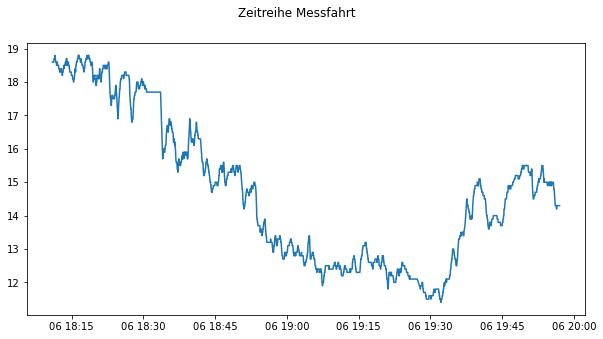

In [7]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T[C]"], label="T Track")
fig.suptitle("Zeitreihe Messfahrt")

Text(0.5, 0.98, 'T Leipzig/Halle')

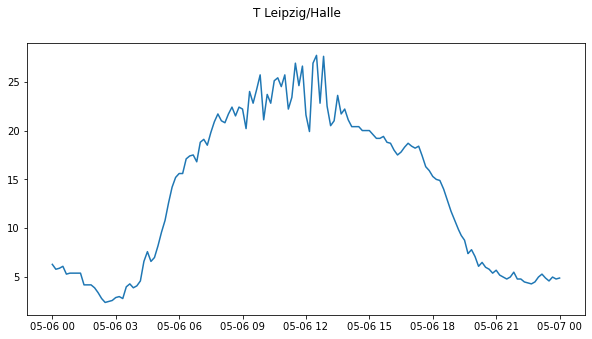

In [8]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
fig.suptitle("T "+station)

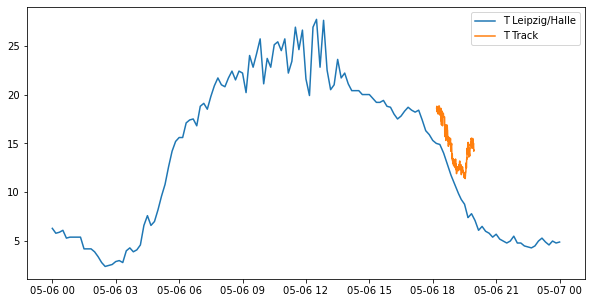

In [9]:

fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
ax.plot(df_compared["T[C]"], label="T Track")
ax.legend()

(19118.757627314815, 19118.831238425926)

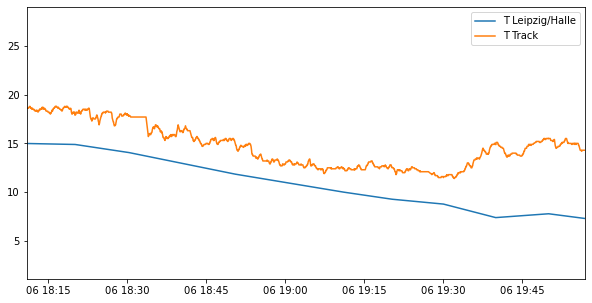

In [10]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared["T"], label="T "+station)
ax.plot(df_compared["T[C]"], label="T Track")
ax.legend()
ax.set_xlim([min(ds.time),max(ds.time) ])

Text(0.5, 0.98, 'Temperaturdifferenz Messfahrt - Leipzig/Halle')

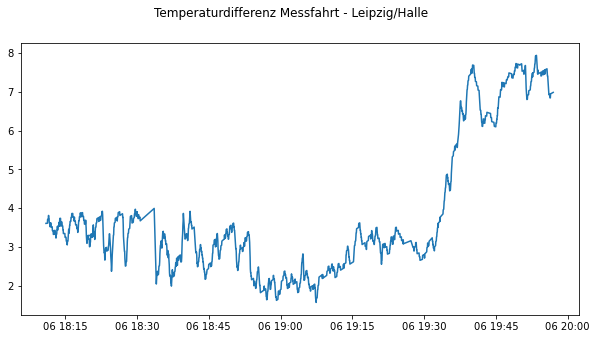

In [11]:
fig, ax=plt.subplots(figsize=(10, 5))
ax.plot(df_compared.T_diff)
fig.suptitle("Temperaturdifferenz Messfahrt - "+station)

In [12]:
map_OSM2 = folium.Map(location=[51.33,12.39], zoom_start=13, tiles='Stamen Terrain')


lat = ds.lat
lon = ds.lon
t = df_compared['T_diff']
print(t)

colormap = cm.LinearColormap(colors=['darkblue', 'blue', 'cyan', 'green','yellow', 'orange', 'red','firebrick'],
                             index=[-5,-2,-1,1,2,5],
                             vmin = -5, vmax=30,
                            # tick_labels = [-10,0,10,20,30,40],
                            # scale_width= 800, scale_height=20,
                             caption=r'Temperature [°C]')

fg = folium.FeatureGroup() 
for pt in ds.index:
                  
    color = colormap(t[pt])              
    fg.add_child(folium.CircleMarker(location=[lat[pt],lon[pt]],
                                     radius=4,
                                     fill=True,
                                     color=color,
                                     fill_color=color))
    
    
    
    
map_OSM2.add_child(fg)
#map_OSM.add_child(colormap)

map_OSM2

time
2022-05-06 00:00:00   NaN
2022-05-06 00:10:00   NaN
2022-05-06 00:20:00   NaN
2022-05-06 00:30:00   NaN
2022-05-06 00:40:00   NaN
                       ..
2022-05-06 23:20:00   NaN
2022-05-06 23:30:00   NaN
2022-05-06 23:40:00   NaN
2022-05-06 23:50:00   NaN
2022-05-07 00:00:00   NaN
Name: T_diff, Length: 2211, dtype: float64
